# A Character Recognition Tool


This notebook will show you how to perform character recognition in visual media using a YouTube clip from Parks and Recreation as an example. 


# Part I - Setup Prerequisites
------------------------------

Installing necessary libraries 
(you can exectute all subsections or unfold them and walk through on a cell by cell basis)

**Installation of these libraries were tested in Google Colab**

In [ ]:
%%capture
!pip install seaborn==0.11.1
!pip install tqdm
!pip install scikit-learn==0.22.2.post1
!pip install matplotlib==3.2.2
!pip install scipy==1.4.1
!pip install pliers==0.4.0
!pip install face_recognition==1.3.0
!sudo apt-get install ffmpeg
!sudo apt-get install python3-magic
!pip install python-magic==0.4.18
!pip install youtube-dl==2021.2.10

In [ ]:
import sys, PIL, os
import numpy as np
import pandas as pd 
import face_recognition
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import notebook
from pliers.filters import FrameSamplingFilter
from PIL import Image

%matplotlib inline

# Part II - Provide Input Info
------------------------------

STEP 1: Name your project
*   Create a name for your project
*   In this example '''CRT_ParksAndRecreation''' is the project name

STEP 2: Save your Video into input_video folder
*   Here we downloaded a clip from Parks and Recreation from YouTube, named it sample_video, and directly saved it into the folder

STEP 3: Save your Face Templates into the character_image folder
*   Here we dowloaded images of Amy Poehler and Aziz Ansari (the actors for Leslie Knope and Tom Haverford) from IMDb.com and labeled them 01_LESLIE and 02_TOM



In [ ]:
project_name = "CRT_ParksAndRecreation"

os.mkdir(project_name)
os.chdir(project_name)
os.mkdir('input_video')

# Enter youtube URL
!youtube-dl https://www.youtube.com/watch?v=OI4p9FSDxy0 --format mp4 --output './input_video/sample_video.mp4'


# Enter character name and provide the link to a sample image (.jpg format/ending)
characters = { 
               '01_LESLIE'   :'https://m.media-amazon.com/images/M/MV5BYjIzMDA0NmUtMTlhZi00ZDU3LTkzYWMtZDhkYTU1ZDJlMGRkXkEyXkFqcGdeQXVyNzcwODE0OTk@._V1_UY317_CR32,0,214,317_AL_.jpg',                 
               '02_TOM'      :'https://m.media-amazon.com/images/M/MV5BMjE5NzYwNDQwN15BMl5BanBnXkFtZTgwNDA2NjQwODE@._V1_UX214_CR0,0,214,317_AL_.jpg',
             }


[youtube] OI4p9FSDxy0: Downloading webpage
[download] Destination: ./input_video/sample_video.mp4
[download] 100% of 16.93MiB in 00:00


# Part III - Executing the CRT (Part 1)
------------------------------
STEP 1: Set a tolerance threshold
*   How liberal or strict do you want the face detection (Default and reconmended is .06)?

STEP 2: Set the algorithm you want to use
*   You have the choice of using either HOG or CNN

STEP 3: Set a framerate
*   The CRT will start at the 1st frame (#0 frame) and analyze every nth frame. For example, if set to 200, the CRT will code the #0 frame, #200 frame, #400 frame, etc.

STEP 4: Set whether to show frames coded
*   Set this as '''True''' if you want to see every frame analyzed (This is good for testing and troubleshooting short videos)
*   Set this as '''False''' if you don't want to see every frame analyzed (This is good for analyzing a large sample of frames)

NOTE 1: Make sure the name of the video file matches with the video reference

NOTE 2: If there is an erorr, the most likely cause is that the CRT did not detect a face in one of the character images files









The current extraction will work on n = 34 frames (with frame rate =200).
The CRT will identify the following characters: 


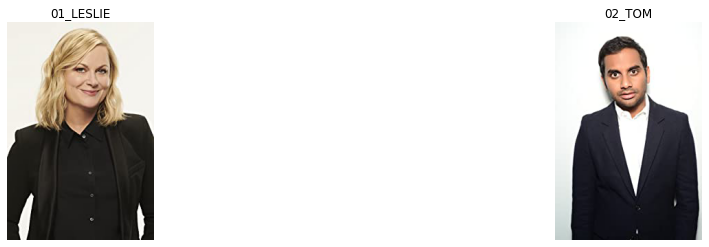

In [ ]:
# change to values between 0 and 1 
# [values towards 0 are more strict, higher values more liberal (default = 0.6)]
tolerance_threshold = 0.6

# Chose type of face_recognition algorithm 
# [default:'hog', alternative: 'cnn' (slower, but more accurate, GPU advised)]
model_to_use ='hog' 

# change to value you prefer 
# [values near 1 are more accurate, higher values will sample every n-th frame.]
rate = 200 

plot_output = False #set to True/False to show/suppress frame images.

# Load video and check frames
sampler          =  FrameSamplingFilter(every = rate)
video_reference  =  './input_video/sample_video.mp4'
frames           =  sampler.transform(video_reference)
n_frames         =  frames.n_frames
print('The current extraction will work on n = ' + str(frames.n_frames) + ' frames (with frame rate =' +str(rate) + ').')

# Import Character Reference Images 
character_url    = list(characters.values())
character_key    = list(characters)

if not os.path.exists('character_images'):
  os.mkdir('character_images')

if not os.path.exists('unrecognized_images'):
  os.mkdir('unrecognized_images')

for current_character in range(len(characters)):
       urllib.request.urlretrieve(character_url[current_character], 
                           './character_images/'+ character_key[current_character] +'.jpg')

character_images    = [i for i in os.listdir('./character_images/') if i.endswith('.jpg')]
character_names     = [f[:-4] for f in list(character_images)] 

n_character_images  = len(character_images) 
print('The CRT will identify the following characters: ')

plt.figure( figsize = (18,4))
for num, x in enumerate(character_images):
    img = PIL.Image.open(os.path.join('./character_images/', x))
    plt.subplot(1,n_character_images ,num+1)
    plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img) 
    sys.stdout.flush()

known_faces = []
for character in character_images:
    known_character_image =  face_recognition.load_image_file('./character_images/' + character)
    known_character_encoding = face_recognition.face_encodings(known_character_image)[0]
    known_faces.append(known_character_encoding)

# Part IV - Executing the CRT (Part 2)
------------------------------
You do not need to change anything here. This will run the CRT to analyze each frame specified. 

In [ ]:
unkonown_face_counter = 0
res                   = []
onsets                = []

# main loop across frames
for curr_frame_number in notebook.tqdm(range(n_frames)):
    
    # load the current frame as an image
    curr_frame = frames.get_frame(curr_frame_number).video.get_frame(curr_frame_number).data
    onsets.append(frames.get_frame(curr_frame_number).onset)

    # if plot_output is set to true in the configuration, frames will be plotted
    if plot_output:
      fig, ax = plt.subplots(1)
      ax.imshow(curr_frame)

    # detect faces and plot them (for now) based on location info...
    face_locations = face_recognition.face_locations(curr_frame, model= model_to_use) #'number_of_times_to_upsample=1', "model='hog'"
    if len(face_locations)>0:
        for curr_face in range(len(face_locations)):  
            l1 = (face_locations[curr_face][2] - face_locations[curr_face][0])
            l2 = (face_locations[curr_face][1] - face_locations[curr_face][3])
            rect = patches.Rectangle((face_locations[curr_face][3], face_locations[curr_face][0]), l1,l2, edgecolor = 'r', facecolor='none')
            if plot_output:
              ax.add_patch(rect)
    if plot_output:          
      plt.axis('off')
    
    # for all detected faces, compute their encodings
    face_encodings = face_recognition.face_encodings(curr_frame, face_locations)

    if len(face_encodings)>0 :
        results = []
        for curr_encoding in range(len(face_encodings)):
            # compare the recognized & encoded faces with the known faces' encodings....
            results.append(face_recognition.compare_faces( known_faces, 
                                                      face_encodings[curr_encoding], 
                                                      tolerance = tolerance_threshold))
        results = np.sum(results, axis=0, dtype = 'bool') 
        
        # if character recognized, get its name
        if (sum(results)>0):
            characters_recognized = [ character_names[i] for i in np.where(results)[0][:]]
            if plot_output:
                plt.text( face_locations[curr_face][0], face_locations[curr_face][3], 
                           str(characters_recognized), color ='red' )
                plt.show()
                sys.stdout.flush()
                
        # if more faces are detected than recognized, unknown faces must be present
        # save those to the unrecognized_images folder for human-in-the-loop decision about whether to include in a 2nd iteration 
        if (len(face_encodings) > sum(results)):
            cc = curr_frame[    face_locations[0][0]:face_locations[0][2], 
                                face_locations[0][3]:face_locations[0][1],
                                :]
            if plot_output:
              plt.imshow(cc)
              plt.text(20,20, 'unrecognized face', color= 'red')
              plt.axis('off')
              plt.show()
            
            im = Image.fromarray(cc)
            unkonown_face_counter += 1
            filename_uf = './unrecognized_images/unknown_face_' + str(unkonown_face_counter) + '.jpg'
            im.save(filename_uf)

        res.append(results)
    else:
        res.append([False] * n_character_images)

# creating result dataframe from list of results
res = np.asarray(res)
new_result = np.zeros((n_frames, n_character_images))
for curr_line in range(n_frames):
    new_result[curr_line,:] = np.asarray(res[curr_line])

df = pd.DataFrame( data     = new_result,
                    columns = character_names );

df.insert(0, 'onset', onsets)

df['date'] = pd.to_datetime(df['onset'], unit='s')
df['time'] = df['date'].dt.strftime("%H:%M:%S")
df = df.drop('date', 1)


# Part V - Result Visualization and Create CSV-File
--------------------------------

This will create a CSV-File of your results and create a barcode visual of when each character appeared in the video.

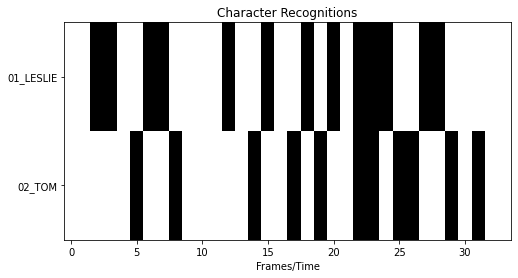

In [ ]:
df.to_csv('../CRT_results_' + project_name + '.csv')

fig, ax = plt.subplots(figsize = (8,4))
ax.imshow(df[character_names].values.T, cmap = 'gray_r', aspect='auto', interpolation='nearest');
ax.set_yticks(np.arange(n_character_images));
ax.set_yticklabels(character_names);
ax.set_title("Character Recognitions");
ax.set_xlabel("Frames/Time");

df.head()